<a href="https://colab.research.google.com/github/jhryals/el-roi-intelligence-triage-system/blob/main/analysis/ner_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# ==============================================================
# MODULE 3: English NER with Grouped Entity Frequency Tables
# ==============================================================

import pandas as pd
import spacy
from collections import Counter
import os
from google.colab import drive

# --------------------------------------------------------------
# 📂 Google Drive Setup
# --------------------------------------------------------------
drive.mount('/content/drive')
PROJECT_PATH = "/content/drive/MyDrive/el-roi"
DATA_PATH = os.path.join(PROJECT_PATH, "data")
os.makedirs(DATA_PATH, exist_ok=True)

# --------------------------------------------------------------
# 📦 Install spaCy
# --------------------------------------------------------------
!pip install --quiet spacy
!python -m spacy download en_core_web_sm

# --------------------------------------------------------------
# Load spaCy English model
# --------------------------------------------------------------
nlp = spacy.load("en_core_web_sm")

# Intelligence-relevant entity labels
INTEL_ENTITY_LABELS = [
    "PERSON", "NORP", "ORG", "GPE", "LOC", "FAC",
    "EVENT", "LAW", "DATE", "TIME", "MONEY", "QUANTITY",
    "PERCENT", "PRODUCT", "LANGUAGE"
]

def extract_entities(text):
    """Extracts entities from English text using spaCy."""
    if not text or not text.strip():
        return []

    doc = nlp(text)
    return [
        {"text": ent.text, "label": ent.label_}
        for ent in doc.ents
        if ent.label_ in INTEL_ENTITY_LABELS
    ]

def process_ner_pipeline(df):
    """Runs NER and adds entities column."""
    df["entities"] = df["translated_summary"].apply(extract_entities)
    return df

def generate_entity_frequency(df):
    """
    Creates a frequency table of all entities across the dataset.
    Returns both:
    - Overall frequency DataFrame
    - Dictionary of frequency DataFrames grouped by label
    """
    all_entities = []
    for entity_list in df["entities"]:
        for ent in entity_list:
            all_entities.append((ent["text"], ent["label"]))

    counter = Counter(all_entities)
    freq_df = pd.DataFrame([
        {"entity": k[0], "label": k[1], "count": v}
        for k, v in counter.items()
    ])
    freq_df = freq_df.sort_values(by="count", ascending=False).reset_index(drop=True)

    # Group by label
    grouped = {}
    for label in INTEL_ENTITY_LABELS:
        grouped[label] = freq_df[freq_df["label"] == label].reset_index(drop=True)

    return freq_df, grouped

# --------------------------------------------------------------
# 📂 Load translated articles
# --------------------------------------------------------------
translated_articles_path = os.path.join(DATA_PATH, "articles_translated.jsonl")
if not os.path.exists(translated_articles_path):
    raise FileNotFoundError(f"❌ Could not find {translated_articles_path}. Please run language_translation.ipynb first.")

df_translated = pd.read_json(translated_articles_path, lines=True)

# --------------------------------------------------------------
# 🚀 Run NER processing
# --------------------------------------------------------------
df_with_entities = process_ner_pipeline(df_translated)

# --------------------------------------------------------------
# 📊 Generate entity frequency tables
# --------------------------------------------------------------
entity_freq_df, grouped_entity_freq = generate_entity_frequency(df_with_entities)

# --------------------------------------------------------------
# 💾 Save outputs
# --------------------------------------------------------------
ner_output_path = os.path.join(DATA_PATH, "articles_ner.jsonl")
entity_freq_path = os.path.join(DATA_PATH, "entity_frequency.csv")

df_with_entities.to_json(ner_output_path, orient="records", lines=True, force_ascii=False)
entity_freq_df.to_csv(entity_freq_path, index=False)

# Save grouped tables separately for analysis
for label, group_df in grouped_entity_freq.items():
    group_df.to_csv(os.path.join(DATA_PATH, f"entity_frequency_{label}.csv"), index=False)

print(f"✅ NER complete. Extracted entities for {len(df_with_entities)} articles.")
print(f"✅ Saved detailed article data to: {ner_output_path}")
print(f"✅ Saved overall entity frequency table to: {entity_freq_path}")
print("✅ Saved grouped frequency tables by label.")

# --------------------------------------------------------------
# 🔍 Preview samples
# --------------------------------------------------------------
print("\nSample entity extractions:")
print(df_with_entities[["translated_summary", "entities"]].head())

print("\nTop 10 most frequent entities overall:")
print(entity_freq_df.head(10))

print("\nTop 5 people:")
print(grouped_entity_freq["PERSON"].head(5))

print("\nTop 5 organizations:")
print(grouped_entity_freq["ORG"].head(5))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 93.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
✅ NER complete. Extracted entities for 145 articles.
✅ Saved detailed article data to: /content/drive/MyDrive/el-roi/data/articles_ner.jsonl
✅ Saved overall entity frequency table to: /content/drive/MyDrive/el-roi/data/entity_frequency.csv
✅ Saved grouped frequency tables by label.

Sample entity extractions:
                                  translated_summary  \
0  The White House envoy is seen with Putin in Mo...   
1  Indian exports will be subje


📊 Generating Top Entities Dashboard...


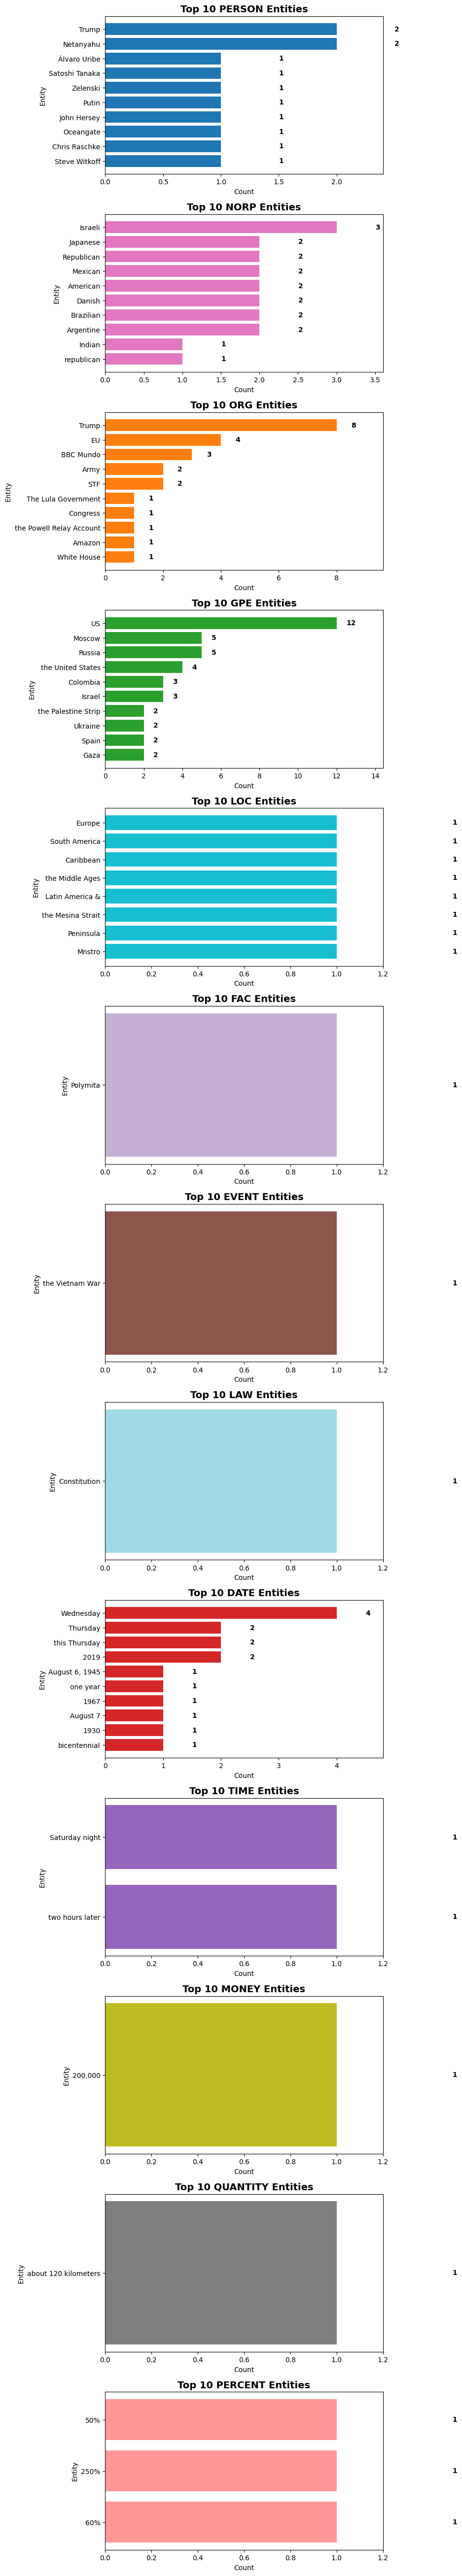

In [4]:
# ==============================================================
# 📊 Visualization: Top Entities Dashboard (Color-Coded + Counts)
# ==============================================================

import matplotlib.pyplot as plt

# Assign a distinct color for each label
ENTITY_COLORS = {
    "PERSON": "#1f77b4",     # Blue
    "ORG": "#ff7f0e",        # Orange
    "GPE": "#2ca02c",        # Green
    "LOC": "#17becf",        # Cyan
    "DATE": "#d62728",       # Red
    "TIME": "#9467bd",       # Purple
    "EVENT": "#8c564b",      # Brown
    "NORP": "#e377c2",       # Pink
    "MONEY": "#bcbd22",      # Olive
    "QUANTITY": "#7f7f7f",   # Gray
    "PERCENT": "#ff9896",    # Light Red
    "FAC": "#c5b0d5",        # Lavender
    "LAW": "#9edae5",        # Light Blue
    "PRODUCT": "#aec7e8",    # Pale Blue
    "LANGUAGE": "#ffbb78"    # Light Orange
}

def plot_top_entities(grouped_entities, top_n=10):
    """
    Plots bar charts for the top N entities per label with color coding and counts.
    """
    num_labels = len(grouped_entities)
    fig, axes = plt.subplots(nrows=num_labels, ncols=1, figsize=(10, 4 * num_labels))

    if num_labels == 1:
        axes = [axes]  # Ensure iterable if only one label

    for ax, (label, df_label) in zip(axes, grouped_entities.items()):
        if df_label.empty:
            ax.set_visible(False)
            continue

        top_entities = df_label.head(top_n)
        bar_color = ENTITY_COLORS.get(label, "steelblue")
        max_count = top_entities["count"].max()

        bars = ax.barh(top_entities["entity"], top_entities["count"], color=bar_color)
        ax.set_xlim(0, max_count * 1.2)  # Add some breathing room

        # Add count labels to the right of each bar
        for bar, count in zip(bars, top_entities["count"]):
            ax.text(
                bar.get_width() + 0.5,  # X position (just past end of bar)
                bar.get_y() + bar.get_height() / 2,  # Y position (vertically centered)
                str(count),
                va="center",
                fontsize=10,
                fontweight="bold"
            )

        ax.set_title(f"Top {top_n} {label} Entities", fontsize=14, fontweight="bold")
        ax.set_xlabel("Count")
        ax.set_ylabel("Entity")
        ax.invert_yaxis()

    plt.tight_layout()
    plt.show()

# --------------------------------------------------------------
# 🚀 Show the dashboard
# --------------------------------------------------------------
print("\n📊 Generating Top Entities Dashboard...")
plot_top_entities(grouped_entity_freq, top_n=10)
